## Modelling a Beacon Chain Mass Exodus Event

The following simulations are derived from the [Ethereum Consensus Specs](https://github.com/ethereum/consensus-specs/blob/5337da5dff85cd584c4330b46a881510c1218ca3/specs/phase0/beacon-chain.md).

The following situations are examining:
- Maximum rate of withdrawls for a given churn limit
- Maximum rate of withdrawls for an amount of ether staked
- Time to pass a blockage in withdrawal queue based on exiting network share (matched by new deposits)
- Time to pass a blockage in withdrawal queue based on exiting network share (unmatched by new deposits)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set(
    rc={
        "figure.figsize":(10, 6.5), 
        "figure.subplot.left":0.10,
        "figure.subplot.right":0.95,
        "figure.subplot.top":0.92,
    }
) # Standardized figure formatting

In [2]:
""" As per the Ethereum consensus specs """

SECONDS_PER_SLOT = 12
SLOTS_PER_EPOCH = 2**5 # 32

MIN_PER_EPOCH_CHURN_LIMIT = 4
CHURN_LIMIT_QUOTIENT = 2**16 # 65,536

MAX_EFFECTIVE_BALANCE = 2**5 # 32 ETH or 32 * 10**9 Gwei

# Formula to calculate the Churn Limit:
# churn_limit = max(MIN_PER_EPOCH_CHURN_LIMIT, validators//CHURN_LIMIT_QUOTIENT)
# --> churn_limit = max(4, validators//65536)

""" Inferred quantities """
seconds_per_epoch = SECONDS_PER_SLOT * SLOTS_PER_EPOCH
epochs_per_day = 24 * 60 * 60 / seconds_per_epoch

### Maximum Rate of Withdrawals

- How many validators are able to exit in a day given the current churn limit
  - ... given an arbitrary amount of ether staked.
- What amount of effective ether leaving the beacon chain does this represent.

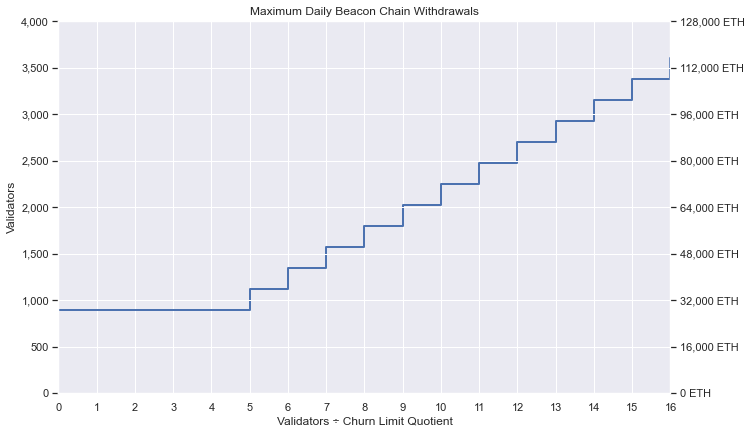

In [10]:
churn_results = np.arange(0, 17)
exit_rate = [epochs_per_day * max(x, MIN_PER_EPOCH_CHURN_LIMIT) for x in churn_results]
# Calculate the maximum exit rates for churn calculation results 0-16 (up to 32mm ETH staked)

plt.title('Maximum Daily Beacon Chain Withdrawals')
plt.xlabel('Validators ÷ Churn Limit Quotient')
plt.ylabel('Validators')
# Figure setup

sns.lineplot(
        x = churn_results, 
        y = exit_rate,     
        lw=2,
        drawstyle='steps-post'
) # Step-plot of validator exit rates

ax1 = plt.gca()
ax1.set_yticks(np.arange(0, 4500, 500))
ax1.set_ylim([0, 4000])
ax1.set_yticklabels(['{:,.0f}'.format(x) for x in ax1.get_yticks()])
# Force to left-y-axis to 500 validator increments


ax2 = ax1.twinx()
ax2.set_yticks([MAX_EFFECTIVE_BALANCE*x for x in ax1.get_yticks()])
ax2.set_ylim([0, MAX_EFFECTIVE_BALANCE*ax1.get_ylim()[1]])
ax2.set_yticklabels(['{:,.0f} ETH'.format(x) for x in ax2.get_yticks()])
# Create a second axis to translate validator counts to ether

ax2.set_xticks(churn_results)
ax2.set_xlim([0,max(churn_results)])
# Force the x-axis to display all churn limit calculations

plt.savefig(
    './figures/withdrawals-per-churn.png', 
    transparent=False, 
    facecolor='w'
)
plt.show()

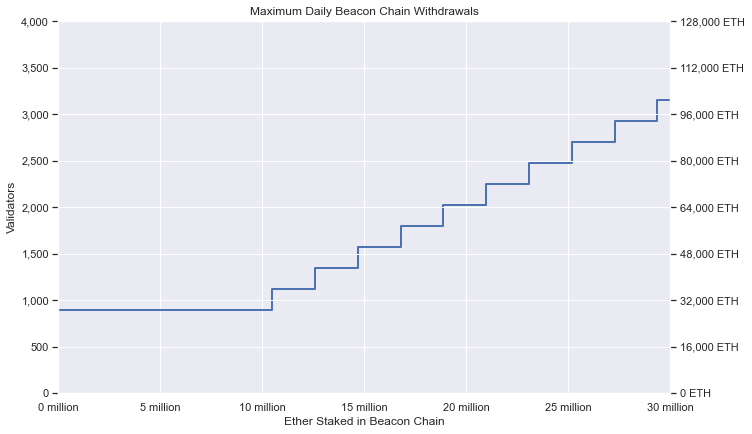

In [9]:
"""
    Repetition of the previous analysis but for an amount of ether staked rather
    than the result of the churn limit calculation.
"""

churn_results = np.arange(0, 17)
exit_rate = [epochs_per_day * max(x, MIN_PER_EPOCH_CHURN_LIMIT) for x in churn_results]
# Calculate the maximum exit rates for churn calculation results 0-16 (up to 32mm ETH staked)


plt.title('Maximum Daily Beacon Chain Withdrawals')
plt.xlabel('Ether Staked in Beacon Chain')
plt.ylabel('Validators')
# Figure setup

sns.lineplot(
        x = churn_results * CHURN_LIMIT_QUOTIENT * MAX_EFFECTIVE_BALANCE / 10**6, 
        y = exit_rate,     
        lw=2,
        drawstyle='steps-post'
) # Step-plot of validator exit rates


ax1 = plt.gca()
ax1.set_yticks(np.arange(0, 4500, 500))
ax1.set_ylim([0, 4000])
ax1.set_yticklabels(['{:,.0f}'.format(x) for x in ax1.get_yticks()])
# Force to left-y-axis to 500 validator increments

ax2 = ax1.twinx()
ax2.set_yticks([MAX_EFFECTIVE_BALANCE*x for x in ax1.get_yticks()])
ax2.set_ylim([0, MAX_EFFECTIVE_BALANCE*ax1.get_ylim()[1]])
ax2.set_yticklabels(['{:,.0f} ETH'.format(x) for x in ax2.get_yticks()])
# Create a second axis to translate validator counts to ether

ax2.set_xlim([0, 30]) # Set plot maximum as 30 million ether
ax2.set_xticks(np.arange(0, 35, 5))
ax2.set_xticklabels(['{:,.0f} million'.format(x) for x in ax2.get_xticks()])
# Clarify that the denomination of the x-axis is millions of ether

plt.savefig(
        './figures/withdrawals-per-ether.png', 
        transparent=False, 
        facecolor='w'
)
plt.show()

### Time to process a mass exodus [matched]

- Examining the time to process an essentially frozen queue caused by the exit of a large validator.
- This simulation assumes a frozen churn limit, ie: exits are matched by new deposits

In [11]:
# Edge case for the fastest rate of withdrawals possible
v_case = CHURN_LIMIT_QUOTIENT * 7 + 1
withdrawl_rate = epochs_per_day * max(MIN_PER_EPOCH_CHURN_LIMIT, v_case//CHURN_LIMIT_QUOTIENT)
speed_max = v_case/withdrawl_rate - 1

# Edge case for the slowest rate of withdrawals possible
v_case = CHURN_LIMIT_QUOTIENT * 8 - 1
withdrawl_rate = epochs_per_day * max(MIN_PER_EPOCH_CHURN_LIMIT, v_case//CHURN_LIMIT_QUOTIENT)
speed_min = v_case/withdrawl_rate + 1

In [12]:
""" 
    Create profiles representing the fastest and the slowest rates of
    withdrawals possible depending on edge cases introduced by 
    integer divison while calculating the churn limit.
"""

t_max_speed = np.arange(0, speed_max)
max_exit_rate = [x/speed_max for x in t_max_speed]
# Fastest possible rate of exits

t_min_speed = np.arange(0, speed_min)
min_exit_rate = [x/speed_min for x in t_min_speed]
# Slowest possible rate of exits

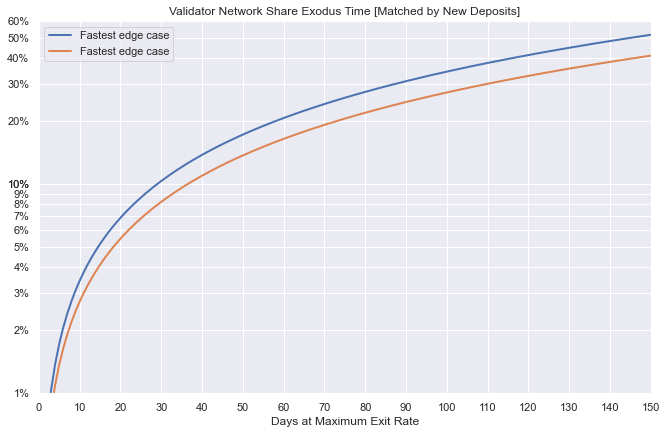

In [15]:
plt.title('Validator Network Share Exodus Time [Matched by New Deposits]')
plt.xlabel('Days at Maximum Exit Rate')
# Figure setup

sns.lineplot(
        x = t_max_speed, 
        y = max_exit_rate, 
        lw=2,
        label='Fastest edge case'
) 

sns.lineplot(
        x = t_min_speed, 
        y = min_exit_rate, 
        lw=2,
        label='Slowest edge case'
) 

ax1 = plt.gca()
ax1.set_xticks(np.arange(0, 200, 10))
ax1.set_xlim([0, 150])
# Limit the plot to the first 150 days of withdrawals

ax1.set_yscale('log')
ax1.set_yticks(np.append(np.arange(1,11)/100, np.arange(1,11)/10)) # Logarithmic steps
ax1.set_ylim([0.01, 0.6])
ax1.set_yticklabels(['{:,.0%}'.format(x) for x in ax1.get_yticks()])
# Customize the y-axis

ax1.legend(loc='upper left')
plt.savefig(
    './figures/exodus-matched.png', 
    transparent=False, 
    facecolor='w'
)
plt.show()

### Time to process a mass exodus [not matched]

- Examining the time to process an essentially frozen queue caused by the exit of a large validator.
- This simulation assumes a decreasing churn limit, ie: exits are not matched by new deposits

In [16]:
"""
    Create a profile for beacon chain validator balances declining at a 
    rate defined by the Churn Limit to model a mass exodus without any 
    new demand for staking.

    Inputs: 
    - val_0: 
        the starting beacon chain validator balance
    - steps: 
        how many days of data to return

    Returns:
        A list of validator balances representing consecutive days

"""
def get_exodus_profile(val_0, steps = 365):
    validator_count = [val_0]
    for ii in range(steps):
        churn = max(validator_count[-1]//CHURN_LIMIT_QUOTIENT, 4)
        validator_count.append(validator_count[-1] - churn*epochs_per_day)
    
    return validator_count

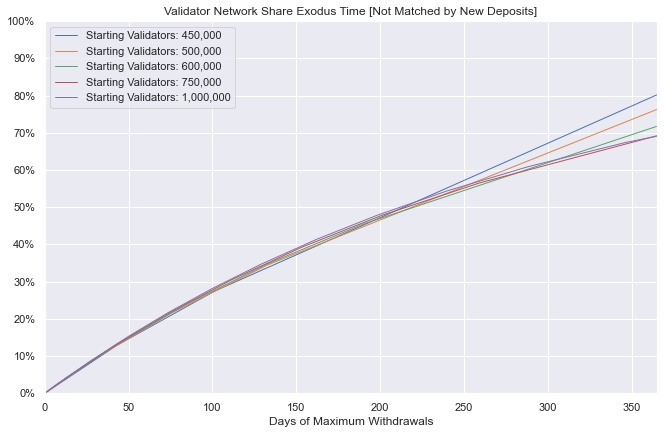

In [18]:
plt.title('Validator Network Share Exodus Time [Not Matched by New Deposits]')
plt.xlabel('Days of Maximum Withdrawals')
# Figure setup

tt = np.arange(0, 365+1)
# x-data representing days in the simulation

# For every defined validator count initial condition create a profile of withdrawals
validator_counts = [450000, 500000, 600000, 750000, 1000000]
for v_count in validator_counts:
    legend_str = '{:,.0f}'.format(v_count)

    sns.lineplot(
        x = tt, 
        y = [1 - x/get_exodus_profile(v_count, 0)[0] for x in get_exodus_profile(v_count)], 
        lw=1,
        label=f"Starting Validators: {legend_str}"
    ) 

ax1 = plt.gca()  
ax1.set_xlim([0, max(tt)])

ax1.set_yticks(np.arange(0, 1.01, 0.1))
ax1.set_ylim([0, 1])
ax1.set_yticklabels(['{:,.0%}'.format(x) for x in ax1.get_yticks()])
# Force tick labels at 10% increments from 0% to 100%

ax1.legend(loc = 'upper left')
plt.savefig(
    './figures/exodus-unmatched.png', 
    transparent=False, 
    facecolor='w'
)
plt.show()